### Imports

In [1]:
import math
from timeit import default_timer as timer

import bayesfunc as bf
import matplotlib
import matplotlib.pyplot as plt
import torch as t
import torch.nn as nn
from torch.distributions import Categorical, Normal
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

from data.regression import RegressionDataset, generate_regression_data
from tqdm.auto import tqdm
import numpy as np

/homes/mojb2/Thesis/GI-PVI/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
matplotlib.style.use('default')
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


Check to move to GPU and fix seed for reproducibility

In [4]:
t.cuda.is_available()
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
print(device)

t.manual_seed(0)

cuda:0


### Data generation

Regression

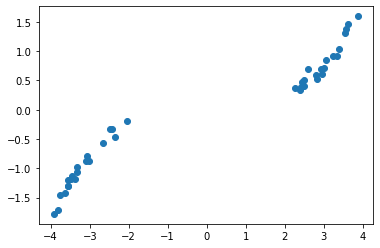

In [13]:
# Generate data
in_features = 1
out_features = 1
num_training_pts = 40

X = t.zeros(num_training_pts, in_features)
X[:int(num_training_pts/2), :] = t.rand(int(num_training_pts/2), in_features)*2. - 4.
X[int(num_training_pts/2):, :] = t.rand(int(num_training_pts/2), in_features)*2. + 2.
y = X**3. + 3*t.randn(num_training_pts, in_features)

#Rescale the outputs to have unit variance
scale = y.std()
y = y/scale

dtype=t.float64

X = X.to(dtype=dtype, device=device)
y = y.to(dtype=dtype, device=device)

train_loader = [(X, y)]
plt.scatter(X.cpu(), y.cpu())
plt.show()

## Regression 2

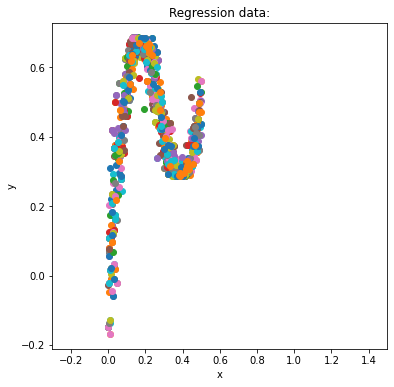

In [16]:
# Parameters
params = {
        'dataloader': {
            'batch_size': 32, 
            'shuffle': True,
            'num_workers': 0},
        'train': {
            'size': 1024,
            'l_lim': 0.0,
            'u_lim': 0.5},
        'test': {
            'size': 1024,
            'l_lim': -0.2,
            'u_lim': 1.4
            }
        }

# Generate data
dtype = t.float64
in_features = 1
out_features = 1
num_training_pts = params['dataloader']['batch_size']
train_dataset = RegressionDataset(**params['train'])
test_dataset = RegressionDataset(**params['test'])

# num_training_pts = 40
# train_loader = generate_regression_data(train=True, size=num_training_pts, batch_size=num_training_pts, shuffle=False) # full batch => GD
# test_loader = generate_regression_data(train=False, size=num_training_pts, batch_size=num_training_pts, shuffle=False)

train_loader = DataLoader(
                train_dataset,
                drop_last=True,  # This should be set to true, else it will disrupt average calculations
                pin_memory=True,
                **params['dataloader']
            )

test_loader = DataLoader(
                test_dataset,
                drop_last=True,  # This should be set to true, else it will disrupt average calculations
                pin_memory=True,
                **params['dataloader']
            )

loader = train_loader
fig, ax = plt.subplots(1, 1, figsize=(6,6))
for i in range(0, len(loader)):

    X, y = next(iter(loader))
    scale = y.std()
    # y /= scale
    X = X.to(dtype=dtype, device=device)
    y = y.to(dtype=dtype, device=device)
    ax.scatter(X.cpu(), y.cpu(), label=f"Batch {i}")


# ax.legend(loc='lower right')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-0.3,1.5)
# ax.set_ylim(-0.02,1.02)
ax.set_title("Regression data:")

plt.show()


### Train and eval

Regular VI

In [88]:
# Simple notebook example

def train_b(net, X, y, num_samples, lr, epochs):
    opt = t.optim.Adam(net.parameters(), lr=lr)
    samples = num_samples
    for i in range(epochs):
        
        opt.zero_grad() # zero out the gradient bc Torch accumulates the gradients on subsequent backward passes
        
        # get network output (calls net.forward) and logpq
        output, logpq, sample_dict = bf.propagate(net, X.expand(samples, -1, -1)) # create X: S x N x D
        ll = Normal(output.to(device), 3/scale.to(device)).log_prob(y).sum(-1).mean(-1)  # log-likelihood
        
        assert ll.shape == (samples,)
        assert logpq.shape == (samples,)
        
        elbo = ll + logpq/num_training_pts
        (-elbo.mean()).backward()
        
        opt.step()
        if i%100==0: 
            print(f"epoch: {i}, elbo: {elbo.mean().item()}")
            plt.scatter(X.flatten().cpu().detach(), output[0, :].flatten().cpu().detach())
            plt.scatter(X.flatten().cpu().detach(), y.flatten().cpu().detach())
            plt.show()
            
    print(elbo.mean().item())

def plot(net, test_loader: DataLoader=None, num_inference_samples=10):

    with t.no_grad():
        xs = t.linspace(-0.3,1.4,100)[:, None].to(device=device, dtype=dtype)
        # xs = t.linspace(-6,6,100)[:, None].to(device=device, dtype=dtype)
        print(xs.shape)
        #set sample=100, so we draw 100 different functions
        ys, _, _ = bf.propagate(net, xs.expand(num_inference_samples, -1, -1))
        mean_ys = ys.mean(0)
        std_ys = ys.std(0)
        plt.fill_between(xs[:, 0].cpu(), mean_ys[:, 0].cpu()-2*std_ys[:, 0].cpu(), mean_ys[:, 0].cpu()+2*std_ys[:, 0].cpu(), alpha=0.5)
        plt.plot(xs.cpu(), mean_ys.cpu())
        plt.scatter(X.cpu(), y.cpu(), c='r')

In [14]:
def plot(net, test_loader: DataLoader=None, num_inference_samples=10):
    xs = []
    targets = []
    preds = []
    stds = []

    with t.no_grad(): # no grad computation

        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            reshaped_data = data.expand(num_inference_samples, *data.shape) # make it S x N x D
        
            outputs, logPQw, sample_dict = bf.propagate(bnn_net, reshaped_data)
            
            pm = outputs.mean(0).flatten().cpu() 
            ps = outputs.std(0).flatten().cpu()

            xs.append(data)
            targets.append(target)
            preds.append(pm)
            stds.append(ps)

        xs = t.cat(xs, dim=1).cpu() # shape: inference_samples x batch_size/N x 1
        xs = xs.flatten()
        preds = t.cat(preds, dim=0).cpu()
        targets = t.cat(targets, dim=1).cpu() # shape: N x 1
        targets = targets.flatten()
        stds = t.cat(stds, dim=0).cpu()

        # Sort in same order
        xs, preds, targets, stds = (np.array(t) for t in zip(*sorted(zip(xs, preds, targets, stds))))

        plt.fill_between(xs, preds-2*stds, preds+2*stds, alpha=0.5)
        plt.plot(xs, preds, label='Prediction mean')
        plt.scatter(xs, targets, label='True values')
        plt.show()

### Model specification 

BNN specification

In [6]:
# Uniform initialization on [-4, 4]
inducing_batch = 128 # can be any shape
inducing_data = t.linspace(-4, 4, inducing_batch)[:, None] # only useful to init on top of training data (which this doesn't)

# could also set to first batch of training data
inducing_batch = 32 # must be equal to train_loader batch size
inducing_data, inducing_targets = next(iter(train_loader))

# could also set to first batch of training data; below is for CIFAR
# inducing_data, inducing_targets = next(iter(train_loader))
# inducing_targets = (t.arange(num_classes) == inducing_targets[:, None]).float() 

## BNN

In [7]:
from bayesfunc.priors import InsanePrior, NealPrior

optional_layer_params = {
    # 'bias': True,
    'prior': NealPrior, #InsanePrior,
    #'inducing_targets': initial value of inducing targets (default None)
    'log_prec_init': -4, # initial precision parameter values; default -4, assumes little data available
    'log_prec_lr': 1, # LR multiplier for precision params
    # 'inducing_targets': inducing_targets
}

hidden_units=50
bnn_net = nn.Sequential(
    bf.GILinear(in_features=1, out_features=hidden_units, inducing_batch=inducing_batch, bias=True, **optional_layer_params),
    nn.ReLU(),
    bf.GILinear(in_features=hidden_units, out_features=hidden_units, inducing_batch=inducing_batch, bias=True, **optional_layer_params),
    nn.ReLU(),
    bf.GILinear(in_features=hidden_units, out_features=1, inducing_batch=inducing_batch, bias=True, full_prec=True, **optional_layer_params)
)

# Wrap model in inducing wrapper
in_features = 1
# bnn_net = bf.InducingWrapper(bnn_net, inducing_shape=(inducing_batch, in_features), inducing_batch=inducing_batch)
bnn_net = bf.InducingWrapper(bnn_net, inducing_data=inducing_data, inducing_batch=inducing_batch)
# Send to GPU
bnn_net = bnn_net.to(device=device, dtype=dtype)

## MFVI

In [8]:
hidden_units=50
mfvi_net = nn.Sequential(
    bf.FactorisedLinear(in_features=1, out_features=hidden_units, bias=True),
    nn.ReLU(),
    bf.FactorisedLinear(in_features=hidden_units, out_features=hidden_units, xbias=True),
    nn.ReLU(),
    bf.FactorisedLinear(in_features=hidden_units, out_features=1, bias=True)
)
mfvi_net = mfvi_net.to(device=device, dtype=dtype)

# Run

In [87]:
# X, y = next(iter(train_loader))
# X = X.to(dtype=dtype, device=device)
# y = y.to(dtype=dtype, device=device)
# scale = y.std()
train_b(net, X, y, num_samples=10, lr=0.05, epochs=100)

epoch: 0, elbo: -2.56347581081879
epoch: 10, elbo: -2.498819897009126
epoch: 20, elbo: -2.489655161647649
epoch: 30, elbo: -2.4938547487419997
epoch: 40, elbo: -2.4834602930473095
epoch: 50, elbo: -2.4827968713345565
epoch: 60, elbo: -2.4859569743678707
epoch: 70, elbo: -2.4872640954753025
epoch: 80, elbo: -2.477061161888548
epoch: 90, elbo: -2.4833640589184784
-2.4850435104540245


torch.Size([100, 1])


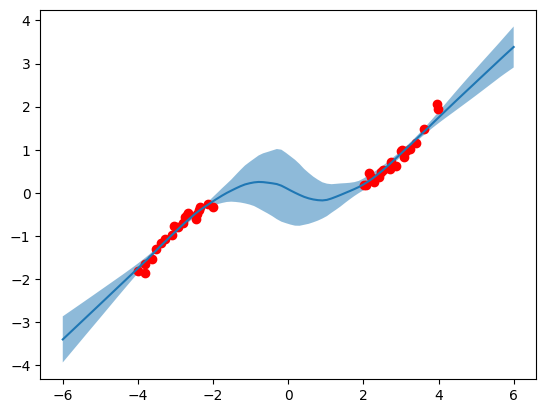

In [78]:
plot(net)

torch.Size([100, 1])


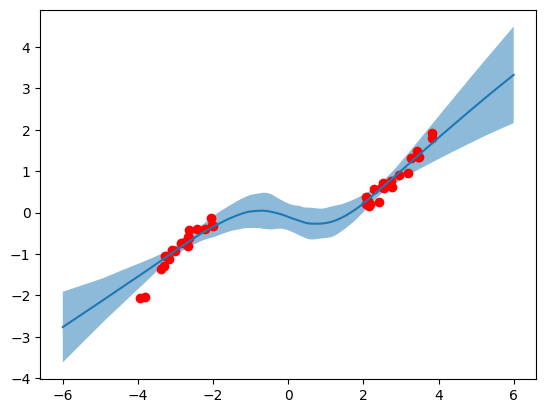

In [27]:
plot(net)

# My version

In [11]:
def train(net, scheduler, train_loader, epoch, num_samples=10, plot = False):
    iters = 0
    total_elbo = 0.
    total_ll = 0.
    total_KL = 0.
    total_error = 0.

    # Tempered beta to have loss not be KL divergence (to optimize eval performance)
    temper = False
    L = 1. # temperature scaling
    tempered_beta = 0.1*math.floor((epoch-1)/10.)/L if (temper and epoch < 100) else 1/L
    beta = 1/L

    for data, target in train_loader:
        opt.zero_grad() # zero out the gradient (Torch accumulates across epochs otherwise)
        
        data, target = data.to(device), target.to(device)
        data = data.expand(num_samples, *data.shape) # make it S x N x D
        
        outputs, logPQw, _ = bf.propagate(net, data)
        
        # Classification: compute log likelihood estimate via outputs 
        # dist| = Categorical(logits=outputs)
        # ll = dist.log_prob(target).mean() 

        if plot and epoch%10==0:
            plt.scatter(data[0, :].flatten().cpu().detach(), outputs[0, :].flatten().cpu().detach())
            plt.scatter(data[0, :].flatten().cpu().detach(), target.flatten().cpu().detach())
            plt.show()

        # Regression:
        ll = Normal(outputs.to(device), 3/scale.to(device)).log_prob(target).sum(-1).mean(-1)  
        
        # Compute objectives
        nloss = ll.mean() + tempered_beta * logPQw.mean()/ num_training_pts  # tempered ELBO
        elbo = ll + beta * (logPQw / num_training_pts)

        (-elbo.mean()).backward()  
        opt.step()

        # For classification only
        # output = outputs.log_softmax(-1).logsumexp(0) - math.log(outputs.shape[0])
        # pred = output.argmax(dim=-1, keepdim=True)
        # correct = pred.eq(target.view_as(pred)).float().mean()
        
        error = (outputs.mean() - y)
        
        iters         += 1
        total_elbo    += elbo.mean().item()
        total_ll      += ll.mean().item()
        total_KL      -= (beta*logPQw.mean()/num_training_pts).item()
        total_error   += error.sum()
    
    if epoch % 50 == 0: scheduler.step()

    return (total_elbo/iters, total_ll/iters, total_KL/iters, total_error/iters)

In [12]:
net = bnn_net

lr = 0.10
opt = t.optim.Adam(net.parameters(), lr=lr)
scheduler = ExponentialLR(opt, gamma=0.99)
epochs = 10000

epoch = []
train_elbo = []
train_ll = []
train_KL = []
test_ll = []
train_err = []

pbar = tqdm(range(epochs), position=0, leave=True)
start_time = timer()
prev_time = timer()
for _epoch in pbar:
    
    _elbo, _train_ll, _train_KL, _train_err = train(net, scheduler, train_loader, _epoch)

    epoch.append(_epoch)
    train_elbo.append(_elbo)
    train_ll.append(_train_ll)
    train_KL.append(_train_KL)
    train_err.append(_train_err)

    # with t.no_grad():
    #     _test_ll, _test_correct = test()
    # test_ll.append(_test_ll)
    # test_correct.append(_test_correct)

    if _epoch%10 == 0:
        report_time = timer() - prev_time
        prev_time += report_time
        total_time = timer() - start_time

        report = f"epoch: {_epoch:03d}, time: {report_time: 3.2f} (total {total_time:3.2f}), elbo: {_elbo:.3f}, KL: {_train_KL:.3f}, err: {_train_err:.3f}"
        pbar.set_description(report)

        # print(f"epoch: {_epoch:03d}, time: {report_time: 3.2f} (total {total_time:3.2f}), elbo: {_elbo:.3f}, KL: {_train_KL:.3f}, err: {_train_err:.3f}", flush=True)
    
print(train_elbo[-1])

epoch: 3980, time:  3.79 (total 1455.65), elbo: -3.859, KL: -0.000, err: -14.158:  40%|███▉      | 3982/10000 [24:16<36:40,  2.73it/s]


KeyboardInterrupt: 

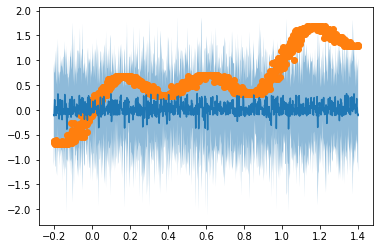

In [21]:
plot(bnn_net, test_loader)

In [31]:
t.cuda.empty_cache()
print(t.cuda.memory_summary(device=None, abbreviated=False))


In [ ]:
train_b(mfvi_net, X, y, 10, 0.10, 1000)

torch.Size([100, 1])


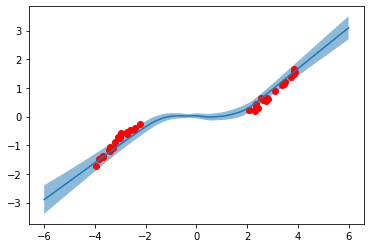

In [17]:
plot(mfvi_net)

torch.Size([100, 1])


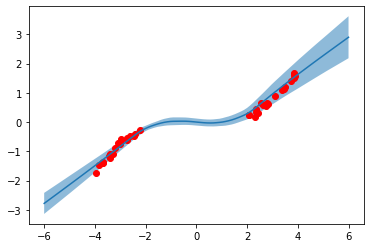

In [14]:
plot(mfvi_net)

In [83]:
num_inference_samples=10
# net.eval() # dropout & batch norm off

xs = []
targets = []
preds = [] 
with t.no_grad(): # no grad computation

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)
        data = data.expand(num_inference_samples, *data.shape) # make it S x N x D
    
        outputs, logPQw, sample_dict = bf.propagate(net, data)
        
        pm = outputs.mean(0).flatten().cpu() 
        ps = outputs.std(0).flatten().cpu()

        # plt.fill_between(data[0].flatten().cpu(), pm-2*ps, pm+2*ps, alpha=0.5)
        # plt.show()

        xs.append(data)
        targets.append(target)
        preds.append(outputs)

    xs = t.cat(xs, dim=1).cpu() # shape: inference_samples x batch_size/N x 1
    preds = t.cat(preds, dim=1).cpu()
    targets = t.cat(targets, dim=1).cpu() # shape: N x 1


In [ ]:
pm = outputs.mean(0).flatten().cpu() 
ps = outputs.std(0).flatten().cpu() 
xs = data[0, :].cpu().detach().flatten()
lb = pm-2*ps
ub = pm+2*ps


plt.fill_between(xs, lb.cpu().detach(), ub.cpu().detach(), alpha=0.5)

plt.plot(xs, pm.cpu().detach())


torch.Size([100, 1])


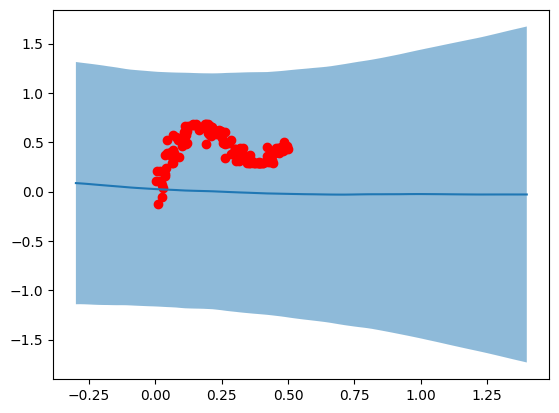

In [77]:
plot(bnn_net)

torch.Size([100, 1])


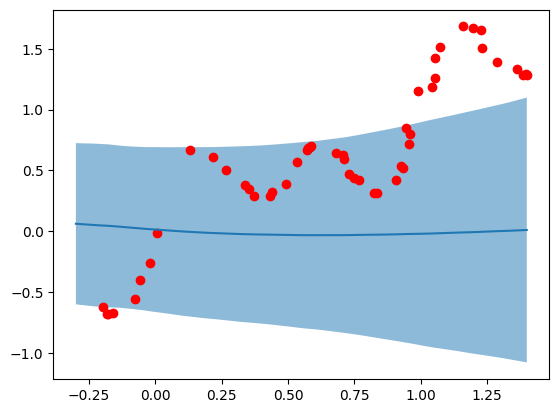

In [72]:
plot(net)